In [ ]:
# Link to paper: https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=9971386
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torchvision.io import read_image
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt

from isar_dataset import ISARDataset

## Model Definitions

In [ ]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=0):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x
    
class CNN(nn.Module):
    def __init__(self, in_channels=1):
        super().__init__()
        self.cnn_layers = nn.Sequential(
            ConvBlock(in_channels, 8),
            ConvBlock(8, 8),
            ConvBlock(8, 8),
            ConvBlock(8, 8),
            nn.MaxPool2d(kernel_size=2, stride=2),

            ConvBlock(8, 16),
            ConvBlock(16, 16),
            ConvBlock(16, 16),
            nn.MaxPool2d(kernel_size=2, stride=2),

            ConvBlock(16, 32),
            ConvBlock(32, 32),
            ConvBlock(32, 32),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        return x

In [ ]:
class BiLSTM(nn.Module):
    def __init__(self, hidden_size, num_classes):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = 2
        self.lstm = nn.LSTM(2592, self.hidden_size, self.num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(self.hidden_size * 2, num_classes)

    def forward(self, x):
        # Initialize hidden and cell states (only needs to be done once)
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device) 
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)

        # Forward pass through LSTM
        out, _ = self.lstm(x, (h0, c0))  

        # Extract last hidden state
        return out[:, -1, :]

class CNN_BiLSTM(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.cnn = CNN()
        hidden_size = 1000
        self.bilstm = BiLSTM(hidden_size, num_classes)
        self.fc1 = nn.Linear(2 * hidden_size, 100)
        self.fc2 = nn.Linear(100, num_classes)

    def forward(self, x):
        B, seq_length, C, H, W = x.shape

        # Process images in sequence via CNN independently
        cnn_out = []
        for i in range(seq_length):
            img = x[:, i, :, :, :]
            img = self.cnn(img)
            img = img.flatten(1)
            cnn_out.append(img)
        x = torch.stack(cnn_out, dim=1)
        
        x = self.bilstm(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.softmax(x, dim=1)

        return x

## Training

In [ ]:
# 0. Declare constants
SEQ_LENGTH = 3
NUM_CLASSES = 4
BATCH_SIZE = 4
MODEL_PATH = 'cnn_bilstm_model.pth'

# 1. Data Preparation
center_crop = transforms.CenterCrop((120, 120))

# TODO: Sampler instead of logic within dataloader -- faster, cleaner
train_dataset = ISARDataset('test/test_labels.csv', 'test/data/', seq_length=SEQ_LENGTH, transform=center_crop)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)

# 2. Model and Optimization
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN_BiLSTM(num_classes=NUM_CLASSES).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adjust learning rate as needed

# 3. Training Loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")  # Progress bar

    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        # Forward, backward pass + optimize
        outputs = model(images)
        loss = criterion(outputs, labels)  # CrossEntropyLoss automatically handles log_softmax
        loss.backward()
        optimizer.step()

        if (i + 1) % 2 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {loss.item():.4f}')

torch.save(model.state_dict(), MODEL_PATH)

tensor([[0.0041, 0.0116, 0.1291, 0.8552]])


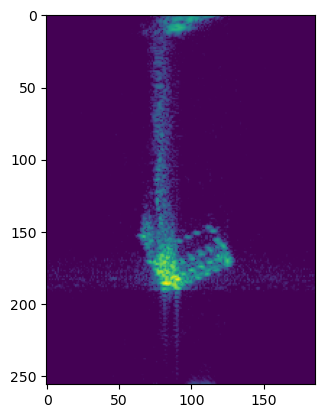

In [55]:
IMG_PATH = 'data/raw/image_23822.png'

image = read_image(IMG_PATH).float()
plt.imshow(image.permute(1, 2, 0).int())

saved_model = CNN_BiLSTM(num_classes=4)
saved_model.load_state_dict(torch.load(MODEL_PATH))
saved_model.eval()

# Add batch and sequence dimensions
image = center_crop(image).unsqueeze(0).unsqueeze(0)

with torch.no_grad():
    output = saved_model(image)
    print(output)